In [26]:
# Import Dependencies 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from imblearn.over_sampling import SMOTE

In [5]:
heart_disease_df = pd.read_csv('heart_2020_cleaned.csv')
heart_disease_df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


Selecting only relevant columns that significantly impact chance of heart disease

In [6]:
heart_disease_df_filtered = heart_disease_df[['HeartDisease', 'Sex', 'AgeCategory', 'Race', 'BMI', 'Smoking', 'AlcoholDrinking', 'Stroke', 'Diabetic', 'PhysicalActivity', 'GenHealth']]
heart_disease_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   Sex               319795 non-null  object 
 2   AgeCategory       319795 non-null  object 
 3   Race              319795 non-null  object 
 4   BMI               319795 non-null  float64
 5   Smoking           319795 non-null  object 
 6   AlcoholDrinking   319795 non-null  object 
 7   Stroke            319795 non-null  object 
 8   Diabetic          319795 non-null  object 
 9   PhysicalActivity  319795 non-null  object 
 10  GenHealth         319795 non-null  object 
dtypes: float64(1), object(10)
memory usage: 26.8+ MB


Checking for any missing values

In [7]:
heart_disease_df_filtered.isna().sum()

HeartDisease        0
Sex                 0
AgeCategory         0
Race                0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
Diabetic            0
PhysicalActivity    0
GenHealth           0
dtype: int64

### Checking if our target variable is binary

Our target variable is the `HeartDisease` column, which should have only two distinct values, `Yes` and `No`.

In [14]:
# for adjusting figure.figsize if using subplots
from pylab import rcParams

import seaborn as sb
import warnings

In [15]:
%matplotlib inline
rcParams['figure.figsize'] = 5,3
rcParams["legend.fontsize"] = 8

warnings.filterwarnings("ignore")

<AxesSubplot:xlabel='HeartDisease', ylabel='count'>

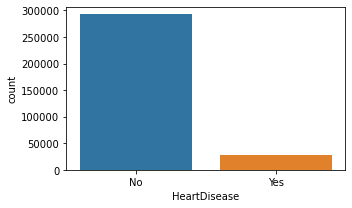

In [16]:
sb.countplot(x='HeartDisease', data=heart_disease_df_filtered)

In [24]:
cm = confusion_matrix('count', 'HeartDisease')
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)
cm_df

ValueError: Found input variables with inconsistent numbers of samples: [5, 12]

The chart above visualizes the extremely significant imbalance within the number of records for `HeartDisease`, indicating an uneven distribution of data among individuals who have heart disease and those who do not. This might skew a trained model's predictions for heart disease to be severely biased. In order to balance out the class distribution, we will use SMOTE (Synthetic Minority Oversampling Technique). But first, all categorical data must be transformed into binary using dummy variables for the SMOTE method to function effectively.

The <b>SMOTE</b> algorithm takes in the closest minority class data entries and creates new combinations based on those entries.

### Converting categorical features to dummy indicators

Gathering all categorical features

In [17]:
categorical_columns = [name for name in heart_disease_df_filtered.columns if heart_disease_df_filtered[name].dtype=='O']

print(f'There are {len(categorical_columns)} categorical features:\n')
print(", ".join(categorical_columns))

There are 10 categorical features:

HeartDisease, Sex, AgeCategory, Race, Smoking, AlcoholDrinking, Stroke, Diabetic, PhysicalActivity, GenHealth


Transforming all categorical attributes into binary dummy variables where `'0'` is the value representing `No` and `'1'` is the value representing `Yes`

In [18]:
categorical_drop_first = [name for name in categorical_columns if name not in ['AgeCategory', 'Race', 'GenHealth']]
categorical_no_drop = [name for name in categorical_columns if name in ['AgeCategory', 'Race', 'GenHealth']]

heart_disease_df_dummy = pd.get_dummies(data=heart_disease_df_filtered, columns=categorical_drop_first, drop_first=True)
heart_disease_df_dummy = pd.get_dummies(data=heart_disease_df_dummy, columns=categorical_no_drop)
heart_disease_df_dummy.head()

,BMI,HeartDisease_Yes,Sex_Male,Smoking_Yes,AlcoholDrinking_Yes,Stroke_Yes,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy),PhysicalActivity_Yes,...,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White,GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good
0,16.60,0,0,1,0,0,0,1,0,1,...,0,0,0,0,1,0,0,0,0,1
1,20.34,0,0,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
2,26.58,0,1,1,0,0,0,1,0,1,...,0,0,0,0,1,0,1,0,0,0
3,24.21,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,23.71,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1


After our conversion, the target features have expanded from the original 11 columns to a new total of 34 columns.

In [19]:
heart_disease_df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 34 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   BMI                                  319795 non-null  float64
 1   HeartDisease_Yes                     319795 non-null  uint8  
 2   Sex_Male                             319795 non-null  uint8  
 3   Smoking_Yes                          319795 non-null  uint8  
 4   AlcoholDrinking_Yes                  319795 non-null  uint8  
 5   Stroke_Yes                           319795 non-null  uint8  
 6   Diabetic_No, borderline diabetes     319795 non-null  uint8  
 7   Diabetic_Yes                         319795 non-null  uint8  
 8   Diabetic_Yes (during pregnancy)      319795 non-null  uint8  
 9   PhysicalActivity_Yes                 319795 non-null  uint8  
 10  AgeCategory_18-24                    319795 non-null  uint8  
 11  AgeCategory_2

### Creating Synthetic Data using the SMOTE method

Synthetic data will be generated using SMOTE, as previously stated, in order to achieve a balanced distribution of data across all classes. The value of `k_neighbors` to be used will be 55, which provides the highest k-nearest neighbors score during the hyperparameter tuning/testing process.

In [29]:
X_features = heart_disease_df_dummy.drop(['HeartDisease_Yes'], axis=1)
y_target = heart_disease_df_dummy['HeartDisease_Yes']

oversample = SMOTE(k_neighbors=55, random_state=0)
print(f"{oversample}")

SMOTE(k_neighbors=55, random_state=0)


Our original count of 27,373 records for the 'with Heart Disease' class has now been balanced to match the 'without Heart Disease' class, resulting in a total of 292,422 records for both classes

In [30]:
X_features_smoted, y_target_smoted = oversample.fit_resample(X_features, y_target)
y_target_smoted = pd.Series(y_target_smoted)

print(f'No. of records before using SMOTE\n{y_target.value_counts()}\n')
print(f'No. of records after using SMOTE\n{y_target_smoted.value_counts()}')

No. of records before using SMOTE
0    292422
1     27373
Name: HeartDisease_Yes, dtype: int64

No. of records after using SMOTE
0    292422
1    292422
Name: HeartDisease_Yes, dtype: int64


### Splitting data into training and test set

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_features_smoted, y_target_smoted, test_size=0.3, random_state=0)

print(f"No. of train datasets: x={X_train.shape} y={y_train.shape}")
print(f"No. of test datasets: x={X_test.shape} y={y_test.shape}\n")

No. of train datasets: x=(409390, 33) y=(409390,)
No. of test datasets: x=(175454, 33) y=(175454,)



### Creating our model

Our predictivd model for heart disease is built using logistic regression with built-in cross-validation.

In [32]:
model = LogisticRegressionCV(solver='lbfgs')
model.fit(X_train, y_train)
print(f"Model type: {model}")

Model type: LogisticRegressionCV()


### Checking for overfitting and underfitting

Our accuracy score is 0.83419 for the training set and 0.83264 for the test set. Due to their similarities, now there is little to no evidence of overfitting.

In [33]:
# Evaluate model on training dataset
train_accuracy = accuracy_score(y_train, model.predict(X_train))
print("Training Accuracy:", round(train_accuracy, 5))

# Evaluate model on testing dataset
test_accuracy = accuracy_score(y_test, model.predict(X_test))
print("Testing Accuracy:", round(test_accuracy, 5))

Training Accuracy: 0.83419
Testing Accuracy: 0.83264


### Evaluating the model

We use a classification report and confusion matrix to view our summary of prediction results and provide a clear snapshot of our model's classification performance.

In [46]:
y_pred_test = model.predict(X_test)

print("Classification Report of Test Dataset\n")
print(classification_report(y_test, y_pred_test))

cm = confusion_matrix(y_test, y_pred_test)
cm_df = pd.DataFrame(
    cm, index=['Predict Positive: 1', 'Predict Negative: 0 '], columns=['Actual Positive: 1', 'Actual Negative: 0']
)
cm_df

Classification Report of Test Dataset

              precision    recall  f1-score   support

           0       0.84      0.81      0.83     87481
           1       0.82      0.85      0.84     87973

    accuracy                           0.83    175454
   macro avg       0.83      0.83      0.83    175454
weighted avg       0.83      0.83      0.83    175454



,Actual Positive: 1,Actual Negative: 0
Predict Positive: 1,71261,16220
Predict Negative: 0,13144,74829


Our model now has an <b>accuracy score of 0.83</b>, indicating the number of accurate predictions relative to the total number of predictions.

In [41]:
accuracy_score_s = (TP + TN) / float(TP + TN + FP + FN)
print(f'Accuracy score: {round(accuracy_score_s, 2)}')

Accuracy score: 0.83


With a <b>precision score of 0.82</b>, representing the number of positive predictions that are accurate as compared to the total number of predicted positives.

In [43]:
precision_score_s = TP / float(TP + FP)
print(f'Precision score: {round(precision_score_s, 2)}')

Precision score: 0.82


And a <b>recall score of 0.85</b> indicates the proportion of actual positive cases that are correctly identified by our model out of all positive cases of heart disease.

In [45]:
recall_score_s = TP / float(TP + FN)
print(f'Recall score: {round(recall_score_s, 2)}')

Recall score: 0.85


In [ ]:
# end